# Clustering Tracks with HDBSCAN

In this notebook we will use an unsupervised clustering alorithm known as HDBSCAN to see if we can identify informative groupings or clusters of tracks that may inform future recommendation engines. We'll follow some of the same pre-processing steps using multilabel binarizer and Singular Value Decomposition (dimensionality reduction).

## Importing Librabries

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import hdbscan

np.random.seed(42)

%matplotlib inline

## Importing Dataset

The df_combined data includes all track meta data, artist meta data, and audio features for every song in our track library

In [4]:
df = pd.read_csv('../data/df_combined.csv')

In [5]:
df.shape

(37028, 26)

In [6]:
df.head()

,Unnamed: 0,track_id,track_name,artist_id,artist_name,album_id,album_name,playlist_id,track_popularity,track_duration,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_genres,related_artist_names,playlist_name
0,0,7DQ5CZjAQdhgDgdnSXxJ7Z,Solid Gold,6n28c9qs9hNGriNa72b26u,PNAU,3g0mfsWlOOUNheV5L3kQKs,Solid Gold,37i9dQZF1DX4dyzvuaRJ0n,58.0,208367.0,...,0.0,0.0541,0.0978,0.000001,0.0836,0.2950,104.983,"['alternative dance', 'aussietronica', 'austra...","['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint
1,1,5p1ex0pXv6jSPJ6QbumQpD,Piece Of Your Heart,0xRXCcSX89eobfrshSVdyu,MEDUZA,0agqVZjOqVtqHkq3pTFPXb,Piece Of Your Heart,37i9dQZF1DX4dyzvuaRJ0n,87.0,152913.0,...,0.0,0.0295,0.0404,0.000160,0.0740,0.6310,124.080,[],"['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint
2,2,1ahVFh0ViDZr8LvkEVlq3B,No Sleep (feat. Bonn),60d24wfXkVzDSfLS6hyCjZ,Martin Garrix,7KJTuTXYSnBGNgAxte3CSg,No Sleep (feat. Bonn),37i9dQZF1DX4dyzvuaRJ0n,84.0,207094.0,...,1.0,0.0326,0.1290,0.000000,0.1210,0.3270,128.133,"['big room', 'edm', 'pop', 'progressive house'...","['AREA21', 'Borgeous', 'KSHMR', 'Dimitri Vegas...",mint
3,3,6nDKrPlXdpomGBgAlO7UdP,SOS,1vCWHaC5f2uS3yhpwWbIA6,Avicii,7Jx7doYIXITyR2LQB0Hvbc,SOS,37i9dQZF1DX4dyzvuaRJ0n,95.0,157202.0,...,0.0,0.0715,0.2720,0.000000,0.1190,0.3760,100.001,"['big room', 'dance pop', 'edm', 'pop']","['Alesso', 'Afrojack', 'Swedish House Mafia', ...",mint
4,4,5TL9e2xgtvJFtNCBsq1CgX,Changa - Blanke Remix,6n28c9qs9hNGriNa72b26u,PNAU,5kwv2A2qAK8pN007hSA56t,Changa,37i9dQZF1DX4dyzvuaRJ0n,59.0,188470.0,...,1.0,0.0431,0.0330,0.119000,0.2720,0.0654,110.086,"['alternative dance', 'aussietronica', 'austra...","['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint


Dropping extra index column

In [7]:
df.drop('Unnamed: 0', axis = 1, inplace=True)

### Creating Song/Artist Identifier

For our final recommendation system we'll want to input a track and return the most similar songs based on the Cosine Similarity score. To better identify tracks in the library, we'll create a new field which is a combination of the `track_name`, `artist_name`, and `playlist_name'. This field will become our unique identifier for a given song

In [8]:
df['track_artist_playlist'] = df['track_name']+'_'+df['artist_name']+'_'+df['playlist_name']

In [9]:
df.head()

,track_id,track_name,artist_id,artist_name,album_id,album_name,playlist_id,track_popularity,track_duration,artist_popularity,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_genres,related_artist_names,playlist_name,track_artist_playlist
0,7DQ5CZjAQdhgDgdnSXxJ7Z,Solid Gold,6n28c9qs9hNGriNa72b26u,PNAU,3g0mfsWlOOUNheV5L3kQKs,Solid Gold,37i9dQZF1DX4dyzvuaRJ0n,58.0,208367.0,65,...,0.0541,0.0978,0.000001,0.0836,0.2950,104.983,"['alternative dance', 'aussietronica', 'austra...","['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint,Solid Gold_PNAU_mint
1,5p1ex0pXv6jSPJ6QbumQpD,Piece Of Your Heart,0xRXCcSX89eobfrshSVdyu,MEDUZA,0agqVZjOqVtqHkq3pTFPXb,Piece Of Your Heart,37i9dQZF1DX4dyzvuaRJ0n,87.0,152913.0,74,...,0.0295,0.0404,0.000160,0.0740,0.6310,124.080,[],"['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint,Piece Of Your Heart_MEDUZA_mint
2,1ahVFh0ViDZr8LvkEVlq3B,No Sleep (feat. Bonn),60d24wfXkVzDSfLS6hyCjZ,Martin Garrix,7KJTuTXYSnBGNgAxte3CSg,No Sleep (feat. Bonn),37i9dQZF1DX4dyzvuaRJ0n,84.0,207094.0,86,...,0.0326,0.1290,0.000000,0.1210,0.3270,128.133,"['big room', 'edm', 'pop', 'progressive house'...","['AREA21', 'Borgeous', 'KSHMR', 'Dimitri Vegas...",mint,No Sleep (feat. Bonn)_Martin Garrix_mint
3,6nDKrPlXdpomGBgAlO7UdP,SOS,1vCWHaC5f2uS3yhpwWbIA6,Avicii,7Jx7doYIXITyR2LQB0Hvbc,SOS,37i9dQZF1DX4dyzvuaRJ0n,95.0,157202.0,89,...,0.0715,0.2720,0.000000,0.1190,0.3760,100.001,"['big room', 'dance pop', 'edm', 'pop']","['Alesso', 'Afrojack', 'Swedish House Mafia', ...",mint,SOS_Avicii_mint
4,5TL9e2xgtvJFtNCBsq1CgX,Changa - Blanke Remix,6n28c9qs9hNGriNa72b26u,PNAU,5kwv2A2qAK8pN007hSA56t,Changa,37i9dQZF1DX4dyzvuaRJ0n,59.0,188470.0,65,...,0.0431,0.0330,0.119000,0.2720,0.0654,110.086,"['alternative dance', 'aussietronica', 'austra...","['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint,Changa - Blanke Remix_PNAU_mint


### Creating Final Dataframe

In [10]:
final_cols = ['track_id', 'track_popularity', 'track_artist_playlist',
       'artist_popularity', 'artist_genres',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [11]:
df_final = df[final_cols]

In [12]:
df_final.head()

,track_id,track_popularity,track_artist_playlist,artist_popularity,artist_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7DQ5CZjAQdhgDgdnSXxJ7Z,58.0,Solid Gold_PNAU_mint,65,"['alternative dance', 'aussietronica', 'austra...",0.567,0.946,5.0,-2.245,0.0,0.0541,0.0978,0.000001,0.0836,0.2950,104.983
1,5p1ex0pXv6jSPJ6QbumQpD,87.0,Piece Of Your Heart_MEDUZA_mint,74,[],0.677,0.744,10.0,-6.806,0.0,0.0295,0.0404,0.000160,0.0740,0.6310,124.080
2,1ahVFh0ViDZr8LvkEVlq3B,84.0,No Sleep (feat. Bonn)_Martin Garrix_mint,86,"['big room', 'edm', 'pop', 'progressive house'...",0.440,0.635,11.0,-6.385,1.0,0.0326,0.1290,0.000000,0.1210,0.3270,128.133
3,6nDKrPlXdpomGBgAlO7UdP,95.0,SOS_Avicii_mint,89,"['big room', 'dance pop', 'edm', 'pop']",0.802,0.645,5.0,-6.181,0.0,0.0715,0.2720,0.000000,0.1190,0.3760,100.001
4,5TL9e2xgtvJFtNCBsq1CgX,59.0,Changa - Blanke Remix_PNAU_mint,65,"['alternative dance', 'aussietronica', 'austra...",0.530,0.789,9.0,-5.546,1.0,0.0431,0.0330,0.119000,0.2720,0.0654,110.086


### Set track_id to Index

As track_id is the unique identifier in our dataframe, we'll set this feature as the index

In [13]:
df_final.set_index('track_id', inplace=True)
df_final.head()

,track_popularity,track_artist_playlist,artist_popularity,artist_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
track_id,,,,,,,,,,,,,,,
7DQ5CZjAQdhgDgdnSXxJ7Z,58.0,Solid Gold_PNAU_mint,65,"['alternative dance', 'aussietronica', 'austra...",0.567,0.946,5.0,-2.245,0.0,0.0541,0.0978,0.000001,0.0836,0.2950,104.983
5p1ex0pXv6jSPJ6QbumQpD,87.0,Piece Of Your Heart_MEDUZA_mint,74,[],0.677,0.744,10.0,-6.806,0.0,0.0295,0.0404,0.000160,0.0740,0.6310,124.080
1ahVFh0ViDZr8LvkEVlq3B,84.0,No Sleep (feat. Bonn)_Martin Garrix_mint,86,"['big room', 'edm', 'pop', 'progressive house'...",0.440,0.635,11.0,-6.385,1.0,0.0326,0.1290,0.000000,0.1210,0.3270,128.133
6nDKrPlXdpomGBgAlO7UdP,95.0,SOS_Avicii_mint,89,"['big room', 'dance pop', 'edm', 'pop']",0.802,0.645,5.0,-6.181,0.0,0.0715,0.2720,0.000000,0.1190,0.3760,100.001
5TL9e2xgtvJFtNCBsq1CgX,59.0,Changa - Blanke Remix_PNAU_mint,65,"['alternative dance', 'aussietronica', 'austra...",0.530,0.789,9.0,-5.546,1.0,0.0431,0.0330,0.119000,0.2720,0.0654,110.086


### Checking Null Values

In [14]:
df_final.isnull().sum().sort_values(ascending = False)

tempo                    5830
valence                  5830
liveness                 5830
instrumentalness         5830
acousticness             5830
speechiness              5830
mode                     5830
loudness                 5830
key                      5830
energy                   5830
danceability             5830
track_artist_playlist       5
artist_genres               0
artist_popularity           0
track_popularity            0
dtype: int64

We that we indeed have several songs where we're missing audio feature data. This is somewhat expected as Spotify doesn't make audio features available for all songs. Rather than attempting to impute these values, we'll drop these rows

In [15]:
df_final.dropna(inplace=True)
df_final.shape

/Users/davidbickham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(31194, 15)

We know have 32K tracks in our song library

## One Hot Encoding Artist Genres List

First we'll remove any tracks where the artist_genre list is empty

In [16]:
index_missing_genres = df_final[df_final.artist_genres == '[]'].index

In [17]:
df_final.drop(index = index_missing_genres, axis = 0, inplace = True)
df_final.shape

/Users/davidbickham/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(26887, 15)

After dropping tracks where the artist genres list is missing, we have 27K songs in the library

Now we'll need to convert our genre list back to a Python list, currently it is a string containing a list

In [18]:
import ast

df_final['artist_genres_list'] = df_final['artist_genres'].map(lambda x: ast.literal_eval(x))

/Users/davidbickham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Dropping original `artist_genres`

In [19]:
df_final_genres = df_final.drop(['artist_genres','track_artist_playlist'], axis = 1)

In [20]:
df_final_genres.head()

,track_popularity,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_genres_list
track_id,,,,,,,,,,,,,,
7DQ5CZjAQdhgDgdnSXxJ7Z,58.0,65,0.567,0.946,5.0,-2.245,0.0,0.0541,0.097800,0.000001,0.0836,0.2950,104.983,"[alternative dance, aussietronica, australian ..."
1ahVFh0ViDZr8LvkEVlq3B,84.0,86,0.440,0.635,11.0,-6.385,1.0,0.0326,0.129000,0.000000,0.1210,0.3270,128.133,"[big room, edm, pop, progressive house, tropic..."
6nDKrPlXdpomGBgAlO7UdP,95.0,89,0.802,0.645,5.0,-6.181,0.0,0.0715,0.272000,0.000000,0.1190,0.3760,100.001,"[big room, dance pop, edm, pop]"
5TL9e2xgtvJFtNCBsq1CgX,59.0,65,0.530,0.789,9.0,-5.546,1.0,0.0431,0.033000,0.119000,0.2720,0.0654,110.086,"[alternative dance, aussietronica, australian ..."
2UkF0EWfh0T90ScJzGqnD1,71.0,65,0.427,0.916,4.0,-3.716,0.0,0.1160,0.000156,0.000005,0.1540,0.6880,123.539,"[deep groove house, house, tropical house]"


### One Hot Encoding with MultiLabelBinarizer

The Multilabel Binarizer will iterate through our list and allow us to one hot encode the items in our newly created `artist_genres_list`

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_final_genres_pop = df_final_genres.join(pd.DataFrame(mlb.fit_transform(df_final_genres.pop('artist_genres_list')),
                          columns=mlb.classes_,
                          index=df_final_genres.index))

In [22]:
df_final_genres.shape

(26887, 13)

The resulting data frame now has 1,922 features including all one hot encoded genres and the track/artist meta data

## Singular Value Decomposition

Singular Value Decomposition (SVD) is a dimensionality reduction technique in linear algebra that factorizes any matrix M into the product of 3 separate matrices. The ultimate goal being to reduce a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.

In this analysis, we'll use SVD to both reduce the dimensionalty of our track dataframe and as a means of analyzing commonly co-occurring artist genres to infor future recommendations.

### Scaling the Data

Scaling the data means that we will transform the data so that each feature will have a mean of 0 and a standard deviation of 1. As many of our features have quite different magnitudes, we'll scale our data prior to the SVD transformation

In [23]:
ss = StandardScaler()
df_final_genres_pop_ss = ss.fit_transform(df_final_genres_pop)

/Users/davidbickham/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/davidbickham/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Creating SVD Matrix

The resulting matrix will represent our data in a lower dimensional space of n_components (which we'll specify). We'll start by computing a matrix of 100 components

In [24]:
SVD = TruncatedSVD(n_components=100, random_state=20)
svd_matrix = SVD.fit_transform(df_final_genres_pop_ss)
svd_matrix.shape

(26887, 100)

In [25]:
SVD.components_.shape

(100, 1922)

## Plotting Explained Variance

We can visualize the amount of cumulative variance in our data that is explained by each subsequent component created via SVD

Text(0, 0.5, 'variance ratio')

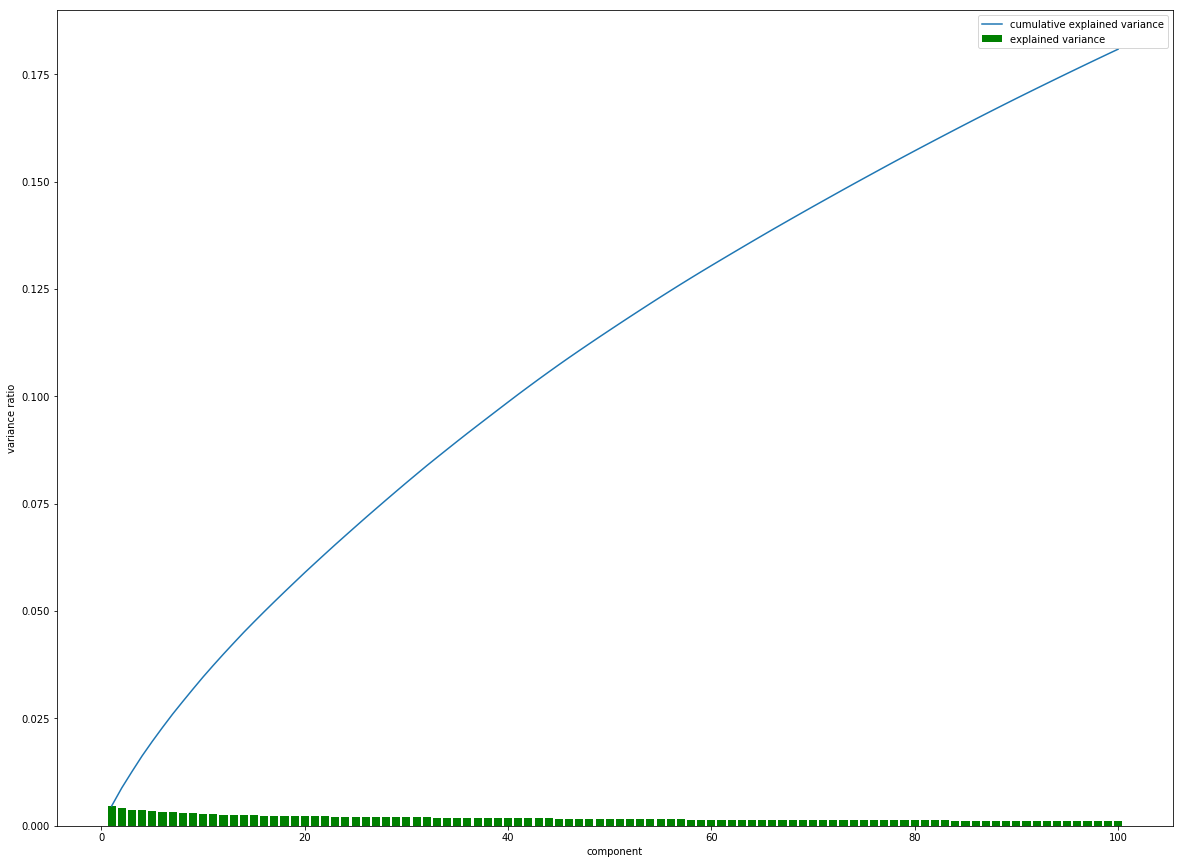

In [26]:
fig = plt.figure(figsize=(20,15))
plt.bar(np.array(range(100))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(100))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend()
plt.xlabel('component')
plt.ylabel('variance ratio')

We can see that the first 100 components we've calculated explain roughly 18% of the variance in our tracks data set

In [27]:
component_names = ["component_"+str(i+1) for i in range(100)]
svd_df = pd.DataFrame(svd_matrix,
                      columns=component_names)

svd_df.insert(0, 'track_id', df_final_genres.index)
svd_df.set_index('track_id', inplace=True)

In [28]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
track_id,,,,,,,,,,,,,,,,,,,,,
7DQ5CZjAQdhgDgdnSXxJ7Z,2.035596,-1.496917,3.776113,0.263415,-0.646796,-1.530263,-1.714502,1.211791,1.207300,-1.151620,...,-0.516145,0.015262,1.043404,1.380739,-1.910107,-0.571241,-1.162905,-1.610178,0.504680,-1.392331
1ahVFh0ViDZr8LvkEVlq3B,-1.428473,-1.617124,1.549980,-0.010941,-0.905047,-4.546911,-1.892264,0.433461,2.388239,0.349556,...,-0.149239,-0.250272,-0.120992,0.209218,0.074228,0.148952,-0.134051,-0.102124,0.036275,0.063159
6nDKrPlXdpomGBgAlO7UdP,-1.389994,-1.445927,1.174145,-0.618994,-1.308264,-2.519386,-1.150983,0.243227,1.762597,0.086157,...,-0.255130,-0.237189,-0.127342,0.288158,-0.007890,0.202737,-0.247919,-0.110277,-0.074902,0.034823
5TL9e2xgtvJFtNCBsq1CgX,2.134044,-1.347201,3.761819,0.312336,-0.329945,-1.487206,-1.727162,1.120685,1.290717,-1.125561,...,-0.505074,0.004686,1.017220,1.358216,-1.891037,-0.570223,-1.185873,-1.621412,0.535278,-1.333220
2UkF0EWfh0T90ScJzGqnD1,-1.143085,-1.312320,1.019998,0.263606,-0.699662,-3.101817,-0.873020,0.383978,0.889724,0.147576,...,0.501551,-0.162140,-0.232025,-0.378920,0.494639,0.426026,-0.254900,0.102184,0.621775,-0.094697


In [29]:
svd_df.shape

(26887, 100)

## Clustering with HDBSCAN

Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) is a clustering algorithm developed by Campello, Moulavi, and Sander. It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters.

Notes:
- We can detect areas of high and low density

- Areas of high density will become a cluster

- Areas of low density will be not clustered/regarded as noise

In [30]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

### Fitting HDBSCAN to the SVD Dataframe

In [31]:
clusterer.fit(svd_df)

/Users/davidbickham/anaconda3/lib/python3.7/site-packages/hdbscan/hdbscan_.py:216: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

Returns the labels from our clusterer

In [32]:
clusterer.labels_

array([ 197, 1075, 1375, ...,  399,  399,  399])

Return the probabilities from our clusterer

In [33]:
clusterer.probabilities_

array([1.        , 0.96175163, 0.78385156, ..., 1.        , 1.        ,
       1.        ])

In [34]:
df_cluster = pd.merge(left = df_final_genres,
                     right = df,
                     how = 'inner',
                     left_index=True,
                     right_on='track_id')

### Append Cluster Labels and Probabilities to the Dataframe

In [35]:
df_cluster['labels'] = clusterer.labels_

In [36]:
df_cluster['pred_prob'] = clusterer.probabilities_

### Investigating our Clusters

Let's see how many unique clusters were created

In [37]:
df_cluster.labels.nunique()

1632

We have 1.6k unique clusters that were created

Let's use the `.describe()` method to look at the distribution of the number of tracks in each cluster

First we'll look at how may tracks were not clustered

In [38]:
df_cluster[df_cluster.labels == -1].shape[0]

8111

8.1k tracks we're not clustered, roughyly A third

Let's create a dataframe that removes unclustered tracks

In [39]:
df_cluster_only = df_cluster[df_cluster['labels'] != -1]

In [40]:
df_cluster_only.shape

(18776, 41)

In [41]:
df_cluster_only.labels.value_counts().describe()

count    1631.000000
mean       11.511956
std        14.025470
min         5.000000
25%         6.000000
50%         8.000000
75%        12.000000
max       321.000000
Name: labels, dtype: float64

we can see that on avg., our clusters contain 12 tracks, with some clusters having as many as 321 tracks

In [42]:
df_cluster_only.labels.value_counts()

1611    321
1549    235
1589    164
1467    118
1470    113
1519    107
1511     90
1535     80
1594     80
1093     77
1616     77
905      75
1028     67
1370     67
1600     66
741      66
1225     57
1090     55
1609     54
1131     53
1622     52
1627     50
1183     47
1437     47
1567     45
1354     45
1604     44
891      43
940      43
1610     42
       ... 
711       5
1351      5
583       5
519       5
471       5
439       5
1087      5
1071      5
343       5
1207      5
1367      5
402       5
728       5
1416      5
434       5
1384      5
1368      5
482       5
744       5
658       5
664       5
1431      5
239       5
834       5
232       5
216       5
184       5
72        5
8         5
0         5
Name: labels, Length: 1631, dtype: int64

Let's look at the dsitribution of how confident we are in our cluster predictions

(array([   76.,   230.,   355.,   475.,   658.,   875.,  1248.,  1580.,
         1798., 11481.]),
 array([0.02809777, 0.125288  , 0.22247822, 0.31966844, 0.41685866,
        0.51404889, 0.61123911, 0.70842933, 0.80561955, 0.90280978,
        1.        ]),
 <a list of 10 Patch objects>)

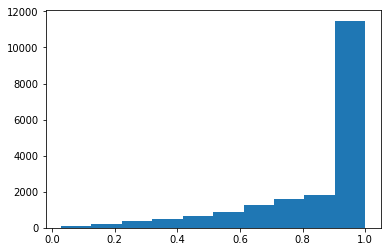

In [43]:
plt.hist(df_cluster_only.pred_prob)

It looks like we're quite confident in the majority of predictions

In [44]:
df_cluster_only.pred_prob.describe()

count    18776.000000
mean         0.856030
std          0.211270
min          0.028098
25%          0.757922
50%          1.000000
75%          1.000000
max          1.000000
Name: pred_prob, dtype: float64

### Examining our Largest Clusters

In [45]:
df_cluster_only[df_cluster_only.labels == 1611]['playlist_name'].value_counts()

Music For Concentration                  45
Peaceful Piano                           36
Piano in the Background                  32
Instrumental Study                       29
Ambient Relaxation                       28
Yoga & Meditation                        22
Cool Down                                18
Stress Relief                            17
Relaxing Massage                         16
SPA Treatment                            12
Calm Vibes                               12
Deep Focus                               11
Reading Chill Out                         9
Intense Studying                          7
Atmospheric Calm                          5
Peaceful Meditation                       4
Dreamy Vibes                              4
Peaceful Piano: American Songbook         4
Productive Morning                        3
Chilled Jazz                              3
Calming Instrumental Covers               1
Workday Lounge                            1
Lava Lamp                       

Interesting! our first cluster seems to be comprised of peaceful/stress relieving playlists

In [46]:
df_cluster_only[df_cluster_only.labels == 1549]['playlist_name'].value_counts()

Lush Lofi                   43
Chill Lofi Study Beats      27
Lo-Fi Beats                 25
Chill Instrumental Beats    22
Jazz Vibes                  19
Tender                      15
Lofi Hip-Hop                14
Mellow Beats                13
Lofi Love                   13
Quiet Hours                 12
Cute Beats                   9
Focus Flow                   5
Brain Food                   4
Drifting Apart               3
Raw Beats                    2
With You                     1
Shisha Lounge                1
Jazztronica                  1
Dreamy Vibes                 1
Lo-fi House                  1
Mellow Mood                  1
Silk Sheets                  1
Workday Lounge               1
Sunshowers                   1
Name: playlist_name, dtype: int64

This cluster seems to be comprised of chill/mellow music

In [47]:
df_cluster_only[df_cluster_only.labels == 1589]['playlist_name'].value_counts()

Chill Instrumental Beats        20
Lo-Fi Beats                     18
Chill Lofi Study Beats          13
Tender                          13
Lush Lofi                       13
Mellow Beats                    11
Jazz Vibes                      11
Quiet Hours                      8
Lofi Hip-Hop                     7
Drifting Apart                   6
Lofi Love                        5
Low-Key                          4
Genre Glitch                     4
Cute Beats                       4
Focus Flow                       4
Shisha Lounge                    3
Jazztronica                      3
Dreamy Vibes                     3
Butter                           2
With You                         2
Raw Beats                        2
Chill Vibes                      1
Eat Sleep Run Repeat 140 BPM     1
Bedroom Pop                      1
Anti Pop                         1
Pop Chillout                     1
Atmospheric Calm                 1
Mellow Mood                      1
Workday Lounge      

Seems to be another chill/mellow collection of tracks

In [48]:
df_cluster_only[df_cluster_only.labels == 1467]['playlist_name'].value_counts()

Country's Greatest Hits:  The '90s             27
Drunk and Hung Over                            10
Country Heartache                              10
Heartland Country                              10
Forever Country                                 7
Country Cookout with Guy Fieri                  6
Country Nights                                  6
Country's Greatest Hits:  The '80s              6
90's Country                                    5
New Traditions: Country Heroes                  4
Tailgate Party                                  4
Greener Pastures                                3
Hot Country                                     3
Morning Run 150–165 BPM                         3
Country by the Grace of God                     3
CMA Award Nominees - 2018                       2
Women of Country                                2
Spotify Singles: Nashville                      2
Country Coffeehouse                             1
Fresh Country                                   1


This one appears to be a country mix

In [49]:
df_cluster_only[df_cluster_only.labels == 1470]['playlist_name'].value_counts()

Country Nights                                 14
Country by the Grace of God                    10
Forever Country                                10
Chillin' on a Dirt Road                        10
Country Gold                                    7
Hot Country                                     5
Drunk and Hung Over                             5
Tailgate Party                                  5
New Traditions: Country Heroes                  4
Country Heartache                               3
Country Coffeehouse                             3
Nashville Stripped                              3
CMA Award Nominees - 2018                       3
Greener Pastures                                3
Country Cookout with Guy Fieri                  3
Hot Country - Top Tracks of 2018                3
Songwriters of Nashville with Charles Esten     2
Spotify Singles: Nashville                      2
Country's Greatest Hits:  The '90s              2
Morning Run 150–165 BPM                         2


More country....

In [50]:
df_cluster_only[df_cluster_only.labels == 1594]['playlist_name'].value_counts()

Mega Hit Mix                         10
Soft Pop Hits                         5
Fangirls Run the World                5
Pumped Pop                            5
Power Run 145 BPM                     3
Fast Pop Run 180 BPM                  3
Fun Run 150–165 BPM                   3
Acoustic Hits: Oldies but Goodies     3
Today's Top Hits                      3
Confidence Boost                      2
Happy Birthday                        2
Arab X                                2
2000s Smash Hits                      2
Dance Pop                             2
Hit Rewind                            2
Feeling Down                          2
The GRAMMYs Official Playlist         2
Pop Hits The Spot                     1
Spotify Singles: Nashville            1
Acoustic Hits                         1
Sunshine Reggae                       1
Country Heartache                     1
Pop Sauce                             1
Teen Party                            1
Love Songs & Chill                    1


Here we've got more of a pop/party/fun mix

## Key Learnings

- Clustering using HDBSCAN seems to provide some promising results. When assessing the playlist make-up of the largest clusters we certainly see that the tracks have a consistent themes such as country, peaceful songs, and chill/lo-fi music.

- In fact, the cluster algoirthm may benefit from a reduced number of clusters as there are currently 1.6k unique clusters

- Next step would be to used these clusters to introduce these clusters into our cosine similarity matrix to see if it improves our recommendations

## Visualizing Clsuters

In [53]:
df_cluster_only[df_cluster_only.labels == 1611]['playlist_name'].value_counts().head(10)

Music For Concentration    45
Peaceful Piano             36
Piano in the Background    32
Instrumental Study         29
Ambient Relaxation         28
Yoga & Meditation          22
Cool Down                  18
Stress Relief              17
Relaxing Massage           16
SPA Treatment              12
Name: playlist_name, dtype: int64

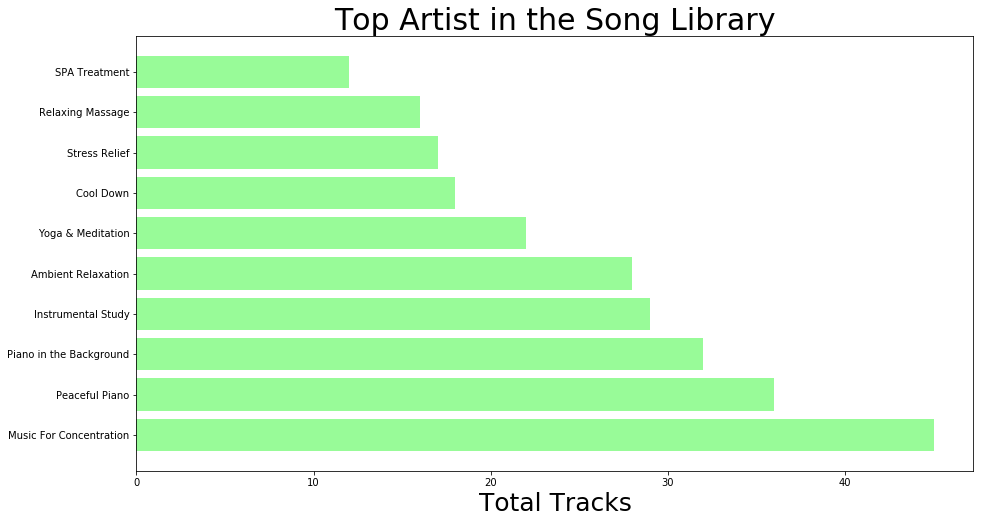

In [54]:
# Create a figure.
plt.figure(figsize=(15,8))

plt.barh(df_cluster_only[df_cluster_only.labels == 1611]['playlist_name'].value_counts().head(10).index
         ,df_cluster_only[df_cluster_only.labels == 1611]['playlist_name'].value_counts().head(10)
         , color='palegreen')
plt.title('Top Artist in the Song Library', fontsize=30)
plt.xlabel('Total Tracks', fontsize=25)
plt.xticks()
# plt.axvline(x=train_clean['saleprice'].mean(),c='darkgrey', linewidth=4, linestyle='--')
# plt.axvline(x=train_clean['saleprice'].median(),c='orange')
;
# Saving the image
plt.savefig('../images/top_artists.png');

In [ ]:
df_cluster_only[df_cluster_only.labels == 1611]['playlist_name'].value_counts().head(10)